In [1]:
# DATASET LOADING AND PROCESSING (DO NEED TO MODIFY)
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn.functional as F


def plot_airfoils(airfoil_x, airfoil_y):
    '''
    plot airfoils: no need to modify
    '''
    idx = 0
    fig, ax = plt.subplots(nrows=4, ncols=4)
    for row in ax:
        for col in row:
            col.scatter(airfoil_x, airfoil_y[idx, :], s=0.6, c='black')
            col.axis('off')
            col.axis('equal')
            idx += 1
    plt.show()


class AirfoilDataset(Dataset):
    '''
    airfoil dataset: no need to modify
    '''
    def __init__(self, path='/content/drive/MyDrive/Colab Notebooks/airfoils'):
        super(AirfoilDataset, self).__init__()
        self._X = []	# x coordinates of all airfoils (shared)
        self._Y = []	# y coordinates of all airfoils
        self.names = []	# name of all airfoils
        self.norm_coeff = 0	# normalization coeff to scale y to [-1, 1]
        airfoil_fn = [afn for afn in os.listdir(path) if afn.endswith('.dat')]

        # get x coordinates of all airfoils
        with open(os.path.join(path, airfoil_fn[0]), 'r', encoding="utf8", errors='ignore') as f:
            raw_data = f.readlines()
            for idx in range(len(raw_data)):
                raw_xy = raw_data[idx].split(' ')
                while "" in raw_xy:
                    raw_xy.remove("")
                self._X.append(float(raw_xy[0]))
        self._X = np.array(self._X)

        # get y coordinates of each airfoils
        for idx, fn in enumerate(airfoil_fn):
            with open(os.path.join(path, fn), 'r', encoding="utf8", errors='ignore') as f:
                self.names.append(fn[:-10])
                raw_data = f.readlines()
                airfoil = np.empty(self._X.shape[0])
                for i in range(len(raw_data)):
                    raw_xy = raw_data[i].split(' ')
                    while "" in raw_xy:
                        raw_xy.remove("")
                    curr_y = float(raw_xy[1])
                    airfoil[i] = curr_y
                    self.norm_coeff = max(self.norm_coeff, np.abs(curr_y))
                self._Y.append(airfoil)

        self._Y = np.array([airfoil / self.norm_coeff for airfoil in self._Y], dtype=np.float32)

    def get_x(self):
        '''
        get shared x coordinates
        '''
        return self._X

    def get_y(self):
        '''
        get y coordinates of all airfoils
        '''
        return self._Y

    def __getitem__(self, idx):
        return self._Y[idx], self.names[idx]

    def __len__(self):
        return len(self._Y)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# VAE

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,64)

        self.fc_mean = nn.Linear(64, latent_dim)
        self.fc_std = nn.Linear(64, latent_dim)

    def forward(self, x):

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        mean = self.fc_mean(x)
        log_var = self.fc_std(x)

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, output_dim)

    def forward(self, x):

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))

        return x


class VAE(nn.Module):
    def __init__(self, airfoil_dim, latent_dim):
        super(VAE, self).__init__()
        self.enc = Encoder(airfoil_dim, latent_dim)
        self.dec = Decoder(latent_dim, airfoil_dim)

    def reparameterize(self, mean, log_var):

        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mean + eps * std

    def forward(self, x):

        mean, log_var = self.enc(x)
        z = self.reparameterize(mean, log_var)
        recon_x = self.dec(z)

        return recon_x, mean, log_var

    def decode(self, z):

        return self.dec(z)

VAE model:
 VAE(
  (enc): Encoder(
    (fc1): Linear(in_features=200, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=64, bias=True)
    (fc_mean): Linear(in_features=64, out_features=16, bias=True)
    (fc_std): Linear(in_features=64, out_features=16, bias=True)
  )
  (dec): Decoder(
    (fc1): Linear(in_features=16, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=200, bias=True)
  )
)
Epoch: [0/30], Batch: 29, loss: 1.2568283081054688
Epoch: [0/30], Batch: 59, loss: 0.967051088809967
Epoch: [0/30], Batch: 89, loss: 1.1113934516906738
Epoch: [1/30], Batch: 29, loss: 1.2306588888168335
Epoch: [1/30], Batch: 59, loss: 0.7745790481567383
Epoch: [1/30], Batch: 89, loss: 0.5744256377220154
Epoch: [2/30], Batch: 29, loss: 0.795558512210846
Epoch: 

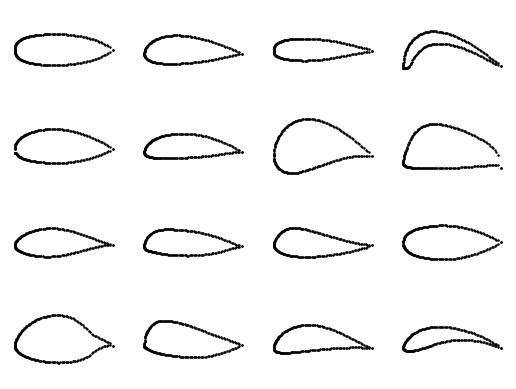

reconstructed airfoils


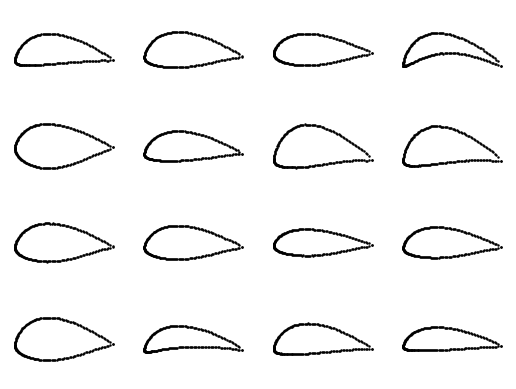

synthesized airfoils


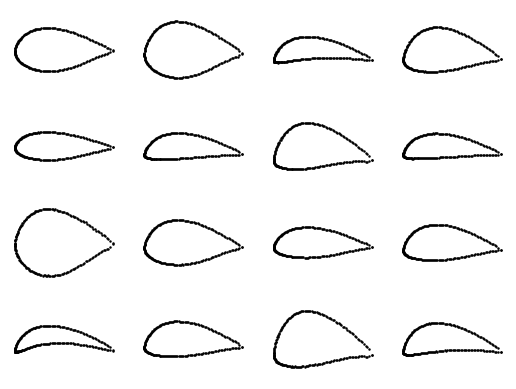

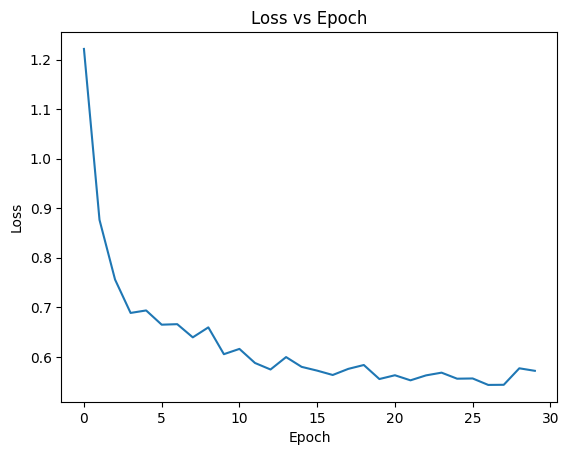

In [32]:
# check if cuda available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# define dataset and dataloader
dataset = AirfoilDataset()
airfoil_x = dataset.get_x()
airfoil_dim = airfoil_x.shape[0]
airfoil_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# hyperparameters
latent_dim = 16 # please do not change latent dimension
lr = 0.001      # learning rate
num_epochs = 30


# build the model
vae = VAE(airfoil_dim=airfoil_dim, latent_dim=latent_dim).to(device)
print("VAE model:\n", vae)

# define your loss function here
# loss = ?

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / x.size(0)
    kl_loss = torch.mean(-0.5*torch.sum(1+ logvar- mu**2 - logvar.exp(),dim=1), dim=0)
    loss = recon_loss + 0.2*kl_loss

    return loss

# define optimizer for discriminator and generator separately
optim = Adam(vae.parameters(), lr=lr)

losses = []

# train the VAE model
for epoch in range(num_epochs):
    epoch_losses = []
    for n_batch, (local_batch, __) in enumerate(airfoil_dataloader):
        y_real = local_batch.to(device)

        # train VAE

        # calculate customized VAE loss
        # loss = your_loss_func(...)

        recon_batch, mu, logvar = vae(y_real)
        loss = vae_loss(recon_batch, y_real, mu, logvar)

        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_losses.append(loss.item())

        # print loss while training
        if (n_batch + 1) % 30 == 0:
            print("Epoch: [{}/{}], Batch: {}, loss: {}".format(
                epoch, num_epochs, n_batch, loss.item()))

    epoch_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(epoch_loss)

# test trained VAE model
num_samples = 100

# reconstuct airfoils
real_airfoils = dataset.get_y()[:num_samples]
recon_airfoils, __, __ = vae(torch.from_numpy(real_airfoils).to(device))
if 'cuda' in device:
    recon_airfoils = recon_airfoils.detach().cpu().numpy()
else:
    recon_airfoils = recon_airfoils.detach().numpy()

# randomly synthesize airfoils
noise = torch.randn((num_samples, latent_dim)).to(device)   # create random noise
gen_airfoils = vae.decode(noise)
if 'cuda' in device:
    gen_airfoils = gen_airfoils.detach().cpu().numpy()
else:
    gen_airfoils = gen_airfoils.detach().numpy()

# plot real/reconstructed/synthesized airfoils
print("real airfoils")
plot_airfoils(airfoil_x, real_airfoils)
print("reconstructed airfoils")
plot_airfoils(airfoil_x, recon_airfoils)
print("synthesized airfoils")
plot_airfoils(airfoil_x, gen_airfoils)

print(" ")
plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

torch.save(vae.state_dict(), '/content/drive/MyDrive/Colab Notebooks/vae.pth')

# GAN

In [28]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, 1)
        # since discriminator is a binary classifier
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # define your feedforward pass
        return self.model(x)


class Generator(nn.Module):
    def __init__(self, latent_dim, airfoil_dim):
        super(Generator, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, airfoil_dim)
        # you can use tanh() as the activation for the last layer
        # since y coord of airfoils range from -1 to 1
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, airfoil_dim),
            nn.Tanh()
        )

    def forward(self, x):
        # define your feedforward pass
        return self.model(x)

Distrminator model:
 Discriminator(
  (model): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
Generator model:
 Generator(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=200, bias=True)
    (5): Tanh()
  )
)
Epoch: [0/60], Batch: 29, Discriminator loss: 0.6550744771957397, Generator loss: 0.6155168414115906
Epoch: [0/60], Batch: 59, Discriminator loss: 0.79807049036026, Generator loss: 0.831487238407135
Epoch: [0/60], Batch: 89, Discriminator loss: 0.4181658923625946, Generator loss: 1.153719425201416
Epoch: [1/60], Batch: 

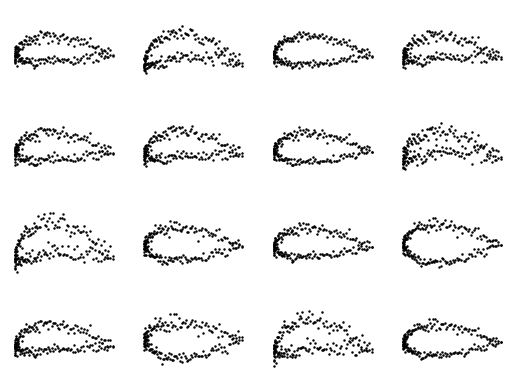

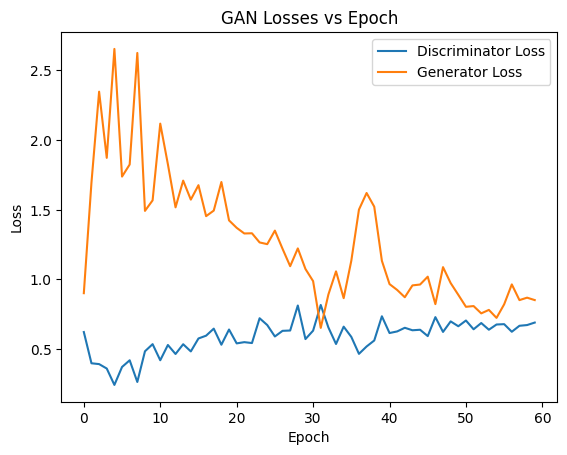

In [34]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# define dataset and dataloader
dataset = AirfoilDataset()
airfoil_x = dataset.get_x()
airfoil_dim = airfoil_x.shape[0]
airfoil_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# hyperparameters
latent_dim = 16 # please do not change latent dimension
lr_dis = 0.0005 # discriminator learning rate
lr_gen = 0.0005 # generator learning rate
num_epochs = 60

# build the model
dis = Discriminator(input_dim=airfoil_dim).to(device)
gen = Generator(latent_dim=latent_dim, airfoil_dim=airfoil_dim).to(device)
print("Distrminator model:\n", dis)
print("Generator model:\n", gen)

# define your GAN loss function here
# you may need to define your own GAN loss function/class
# loss = ?
adversarial_loss = nn.BCELoss()

# define optimizer for discriminator and generator separately
optim_dis = Adam(dis.parameters(), lr=lr_dis)
optim_gen = Adam(gen.parameters(), lr=lr_gen)

dis_losses = []
gen_losses = []

# train the GAN model
for epoch in range(num_epochs):
    epoch_dis_losses = []
    epoch_gen_losses = []
    for n_batch, (local_batch, __) in enumerate(airfoil_dataloader):
        y_real = local_batch.to(device)

        # train discriminator
        optim_dis.zero_grad()

        # calculate customized GAN loss for discriminator
        # enc_loss = loss(...)
        y_pred_real = dis(y_real)
        real_loss = adversarial_loss(y_pred_real, torch.ones_like(y_pred_real).to(device))

        noise = torch.randn((local_batch.size(0), latent_dim)).to(device)
        gen_airfoils = gen(noise)
        y_pred_gen = dis(gen_airfoils.detach())
        fake_loss = adversarial_loss(y_pred_gen, torch.zeros_like(y_pred_gen).to(device))

        loss_dis = (real_loss + fake_loss) / 2

        loss_dis.backward()
        optim_dis.step()

        # train generator

        # calculate customized GAN loss for generator
        # enc_loss = loss(...)

        optim_gen.zero_grad()

        gen_airfoils = gen(noise)
        y_pred_gen = dis(gen_airfoils)
        loss_gen = adversarial_loss(y_pred_gen, torch.ones_like(y_pred_gen).to(device))

        loss_gen.backward()
        optim_gen.step()

        epoch_dis_losses.append(loss_dis.item())
        epoch_gen_losses.append(loss_gen.item())

        # print loss while training
        if (n_batch + 1) % 30 == 0:
            print("Epoch: [{}/{}], Batch: {}, Discriminator loss: {}, Generator loss: {}".format(
                epoch, num_epochs, n_batch, loss_dis.item(), loss_gen.item()))

    avg_dis_loss = sum(epoch_dis_losses) / len(epoch_dis_losses)
    avg_gen_loss = sum(epoch_gen_losses) / len(epoch_gen_losses)
    dis_losses.append(avg_dis_loss)
    gen_losses.append(avg_gen_loss)

# test trained GAN model
num_samples = 100
# create random noise
noise = torch.randn((num_samples, latent_dim)).to(device)
# generate airfoils
gen_airfoils = gen(noise)
if 'cuda' in device:
    gen_airfoils = gen_airfoils.detach().cpu().numpy()
else:
    gen_airfoils = gen_airfoils.detach().numpy()

# plot generated airfoils
print("generated airfoils")
plot_airfoils(airfoil_x, gen_airfoils)

print(" ")
plt.plot(dis_losses, label='Discriminator Loss')
plt.plot(gen_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Losses vs Epoch')
plt.legend()
plt.show()

torch.save(dis.state_dict(), '/content/drive/MyDrive/Colab Notebooks/dis.pth')
torch.save(gen.state_dict(), '/content/drive/MyDrive/Colab Notebooks/gen.pth')


# VAE

For VAE, the model chosen was a simple linear neural network with 4 linear layers in total. The neurons used were 256, 128, 64 as hidden laer neurons and the latent dim and airfoil dim for the input and output layers. There is an encoder and a decoder. The encoder goes from higher neuron to lower neuron and the decoder goes from lower neuron to higher neuron i.e., in the reverse order. With the encoder the mean and the log std were calculated and with decoder the final values were found. ReLu was used for the activation.

The hyper parameters used were learning rate is 0.001 the epochsa are 30 and for reconstruction loss the mse loss was used. For KL loss, it was calculated using the formula.


# GAN

For GAN, the model chosen was a simple neural network with 3 layers. The neurons were 128, 64 as hidden layer neurons and the latent dim and airfoil dim was used for the input and output layers. There is a discrimator and generator in the model. activation functions used were Leaky Relu.

The hyper parameters used were learning rate is 0.0005 for both discrimator and generator the epochs used were 60. The adversarial loss function was BCELoss.

# Compare the synthesized airfoils from VAE and GAN, describe your observation and give a brief explanation.

In VAE, the synthesized airfoils exhibit smoother transitions and fewer artifacts due to the reconstruction loss incorporated in the VAE. Whereas, the GAN images capture finer details and are sharper therefore producing high quality samples. This can be because VAE focuses on latent representation of the data while GAN directly generate realistic samples. The reconstruction loss term in VAE encourages the model to reconstruct input samples accurately. This leads to smoother but less detailed output. VAE produces more diverse samples as they learn from the underlying distribution. As the synthesized airfoils from VAEs might cover a wider range of variations present in the training data. Whereas in GAN there can be mode collapse there showing less diverse generations. Along with that, VAE, produce realistic samples that might struggle to capture details and GANs are known for highly realistic samples therefore, the airfoils generated by GANs exhibit high level of realism capturing both global structures and local details present in the training data. As Gan have generator-discriminator framework to learn the data distribution implicitly therefore helping them to produce high quality realistic samples.